**dataset : https://www.kaggle.com/datasets/omkargurav/face-mask-dataset**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask-dataset/data/without_mask/without_mask_3248.jpg
/kaggle/input/face-mask-dataset/data/with_mask/with_mask_3326.jpg


**importing libraries**

In [2]:
import tensorflow
from tensorflow import keras
# from keras.preprocessing import image

2024-06-01 15:28:55.409165: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 15:28:55.409306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 15:28:55.545373: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import random
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow

#### **setting up random state**

In [4]:
keras.utils.set_random_seed(7)

#### **reading data**

In [5]:
data=[]
categories=['with_mask','without_mask']
for category in categories:
    path=os.path.join('/kaggle/input/face-mask-dataset/data',category)

    if category == 'with_mask':
        label=0
    else:
        label=1

    for file in os.listdir(path):
        img_path=os.path.join(path,file)
        img=cv2.imread(img_path)
        # img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img=cv2.resize(img,(128,128))
        data.append([img,label])

#### in order to avoid any bias towards data, we are doing shuffling

In [6]:
random.Random(7).shuffle(data)

In [7]:
X=[]
y=[]
for feature,label in data:
    X.append(feature)
    y.append(label)
X=np.array(X)
y=np.array(y)
X=X/255
data=None

In [8]:
X.shape,y.shape

((7553, 128, 128, 3), (7553,))

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
X_train.shape,y_train.shape

((6042, 128, 128, 3), (6042,))

### VGG16

In [11]:
from keras import Sequential
from keras.layers import Dense,Flatten,BatchNormalization,Dropout

In [12]:
from keras.applications.vgg16 import VGG16

In [13]:
vgg=VGG16()
fc1_weights=vgg.get_layer('fc1').get_weights()
fc2_weights=vgg.get_layer('fc2').get_weights()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [14]:
base=VGG16(include_top=False,input_shape=(128,128,3))
base.trainable=False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
model=Sequential()

for layer in base.layers:
    model.add(layer)

model.add(Flatten())

model.add(Dense(25088, activation='relu', name='adjust_fc1_input'))

model.add(Dense(4096, activation='relu', name='fc1'))
model.layers[-1].set_weights(fc1_weights)
# model.layers[-1].trainable=False

model.add(Dense(4096, activation='relu', name='fc2'))
model.layers[-1].set_weights(fc2_weights)
# model.layers[-1].trainable=False

model.add(Dense(1,activation='sigmoid'))

In [16]:
from keras.optimizers import Adam

In [17]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ adjust_fc1_input (Dense)        │ (None, 25088)          │   205,545,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 339,810,625 (1.27 GB)

 Trainable params: 325,095,937 (1.21 GB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
epochs=20
history=model.fit(X_train,y_train,epochs=epochs,validation_data=(X_test,y_test),verbose=1)

Epoch 1/20


2024-06-01 15:30:08.042230: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.34782, expected 3.51669
2024-06-01 15:30:08.042296: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.71977, expected 5.88864
2024-06-01 15:30:08.042306: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.95696, expected 6.12583
2024-06-01 15:30:08.042314: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.48105, expected 5.64992
2024-06-01 15:30:08.042322: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.32797, expected 4.49684
2024-06-01 15:30:08.042331: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.7497, expected 4.91857
2024-06-01 15:30:08.042339: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.01592, expected 5.18479
2024-06-01 15:30:08.042346: E external/local_xla/xla/ser

  2/189 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.3984 - loss: 0.8818 

I0000 00:00:1717255816.011749      67 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717255816.034186      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8600 - loss: 0.2925

2024-06-01 15:30:28.349398: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32768: 3.6987, expected 2.89225
2024-06-01 15:30:28.349500: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32769: 5.46176, expected 4.65531
2024-06-01 15:30:28.349510: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32770: 4.83989, expected 4.03344
2024-06-01 15:30:28.349519: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32771: 5.11659, expected 4.31014
2024-06-01 15:30:28.349528: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32772: 4.76542, expected 3.95897
2024-06-01 15:30:28.349540: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32773: 3.75184, expected 2.94538
2024-06-01 15:30:28.349548: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32774: 3.62376, expected 2.81731
2024-06-01 15:30:28.349557: 

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8603 - loss: 0.2920

W0000 00:00:1717255835.110136      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717255836.848713      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-06-01 15:30:38.228378: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16384: 2.87177, expected 2.26216
2024-06-01 15:30:38.228443: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16385: 4.47821, expected 3.8686
2024-06-01 15:30:38.228453: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16386: 4.30997, expected 3.70036
2024-06-01 15:30:38.228461: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16387: 4.353, expected 3.74339
2024-06-01 15:30:38.228469: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16388: 3.86761, expected 3.258
2024-06-01 15:30:38.228477: E external/local_xla/xla/service

189/189 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - accuracy: 0.8606 - loss: 0.2914 - val_accuracy: 0.9431 - val_loss: 20.7421
Epoch 2/20
  2/189 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.9766 - loss: 0.0908

W0000 00:00:1717255840.933083      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.9676 - loss: 0.0874 - val_accuracy: 0.9312 - val_loss: 8.0535
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.9686 - loss: 0.0767 - val_accuracy: 0.9471 - val_loss: 26.0297
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.9857 - loss: 0.0400 - val_accuracy: 0.9530 - val_loss: 56.5405
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.9927 - loss: 0.0201 - val_accuracy: 0.9444 - val_loss: 35.0007
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.9907 - loss: 0.0241 - val_accuracy: 0.9610 - val_loss: 39.4320
Epoch 7/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.9945 - loss: 0.0186 - val_accuracy: 0.9543 - val_loss: 94.8940
Epoch 8/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.9954 - loss: 0.0163 - val_accuracy: 0.9378 - val_loss: 118.4972
Epoch 9/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.9904 - loss: 0.0310 - val_

In [19]:
y_prob=model.predict(X_test)
y_pred=np.where(y_prob>0.5,1,0)

 7/48 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

W0000 00:00:1717256106.445599      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


W0000 00:00:1717256108.184728      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [20]:
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix

In [21]:
acc=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
cm=confusion_matrix(y_test,y_pred)
print(f"accuracy is {acc*100:.2f}%")
print(f"recall is {recall*100:.2f}%")
print(cm)

accuracy is 94.97%
recall is 97.64%
[[689  58]
 [ 18 746]]


In [22]:
import matplotlib.pyplot as plt

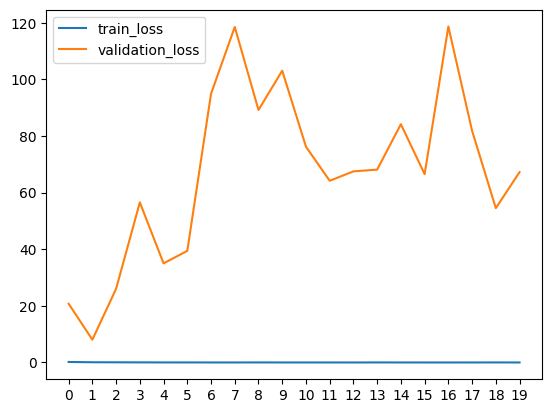

In [23]:
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='validation_loss')
plt.legend()
plt.xticks(np.arange(0, epochs, 1))
plt.show()

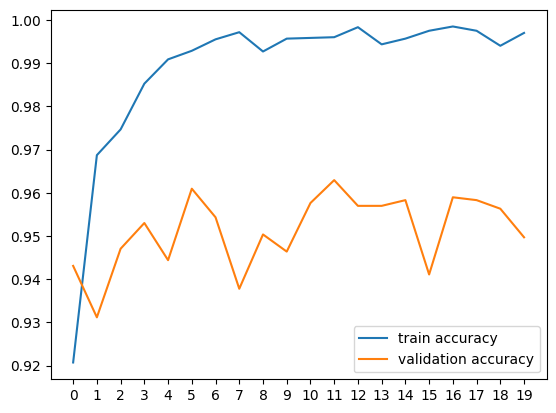

In [24]:
plt.plot(history.history['accuracy'],label='train accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.legend()
plt.xticks(np.arange(0, epochs, 1))
plt.show()